In [1]:
import xarray as xr
import sklearn

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta

In [2]:
#write a function to sum the 37 tidal components for the tide at each gauge location

In [3]:
coef = pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/tidal_constituents_point_reyes.csv')
coef #amplitudes are in meters, phase is in degrees referenced to local, I think speed is degrees per hour

,Constituent #,Name,Amplitude,Phase,Speed,Description
0,1,M2,0.550,318.5,28.984104,Principal lunar semidiurnal constituent
1,2,S2,0.137,316.3,30.000000,Principal solar semidiurnal constituent
2,3,N2,0.121,296.6,28.439730,Larger lunar elliptic semidiurnal constituent
3,4,K1,0.383,99.5,15.041069,Lunar diurnal constituent
4,5,M4,0.001,155.3,57.968210,Shallow water overtides of principal lunar con...
5,6,O1,0.235,92.6,13.943035,Lunar diurnal constituent
6,7,M6,0.000,0.0,86.952320,Shallow water overtides of principal lunar con...
7,8,MK3,0.001,208.2,44.025173,Shallow water terdiurnal
8,9,S4,0.001,240.8,60.000000,Shallow water overtides of principal solar con...
9,10,MN4,0.001,137.3,57.423832,Shallow water quarter diurnal constituent


In [4]:
def hours_since(date):
    #date needs to be type datetime and have hours minutes and seconds
    start = datetime(1983, 1, 1, 0, 0, 0)
    if hasattr(date, "__len__"):
        startvect=np.full(len(date), start)
        diff=(date-startvect) #do this in a vectorized way to save time 
        tvector = []
        for d in diff:
            tvector.append(d.total_seconds()//3600) #but still need to get the seconds and convert for each element
        tvector=np.array(tvector)
        # for d in date:
        #     delt=(d-start).total_seconds() // 3600
        #     np.append(tvector,delt)
    else:
        tvector=(date-start).total_seconds() // 3600
    return(tvector)

In [5]:
# start = datetime(1983, 1, 1, 0, 0, 0)
# startvect=np.full(len(dtvector), start)
# print(startvect)

In [6]:
# (dtvector-startvect)[1].total_seconds()//3600

In [7]:
# diff=dtvector-startvect

In [8]:
# tvector = []#np.empty_like(dtvector)
# for d in diff:
#     tvector.append(d.total_seconds()//3600)
# print(tvector)

In [9]:
# tvector[-1]

In [10]:
# hours_since(datetime(2021,1,1,0,0,0))

In [11]:
# (datetime(2021,1,1,0,0,0,0)-datetime(1983,1,1,0,0,0,0)).total_seconds() //3600

In [12]:
# tvector=hours_since(dtvector)
# tvector

In [13]:
def predict_tide(station_name,dtvector):
    tvector=hours_since(dtvector) #call other function to get time in hours
    #dt needs to be in hours
    if station_name=='point reyes' or station_name=='pr':
        coef = pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/tidal_constituents_point_reyes.csv')
        H0 = 0.946 #mean sea level in m, see https://tidesandcurrents.noaa.gov/datums.html?datum=MLLW&units=1&epoch=0&id=9415020&name=Point+Reyes&state=CA
    elif station_name=='montery bay' or station_name=='mb':
        coef = pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/tidal_constituents_monterey_bay.csv')
        H0 = 0.862 #mean sea level in m, see https://tidesandcurrents.noaa.gov/datums.html?datum=MLLW&units=1&epoch=0&id=9413450&name=Monterey&state=CA
    # From https://tidesandcurrents.noaa.gov/about_harmonic_constituents.html
    # The formula for that calculation is: h = Ho + Sum{ƒH cos[at + (Vo+u) - K]}
        # The terms of the equation are defined as:
        # h = height of tide at any time t.
        # Ho = mean height of water level above datum used for prediction.
        # H = mean amplitude of any constituent A.
        # ƒ = factor for reducing mean amplitude H to year of prediction.
        # a = speed of constituent A.
        # t = time reckoned from some initial epoch such as beginning of year of predictions. (Vo+u) = value of equilibrium argument of constituent A when t = 0.
        # K = epoch of constituent A. 
        
    #iterate through all the constituents (default is degree mode and phase is in degrees) generating a time series for each
    
    #this gives a 2D array with 37 rows and columns for each day in the date vector passed
    st=np.outer(coef.Speed,tvector) #speed times time = degrees
    inside=st + np.array(coef.Phase)[:,None] #speed times time plus the phase offset
    costerm=np.cos(inside*(np.pi/180))
    constit_dates=np.multiply(np.array(coef.Amplitude)[:,None], costerm)
    #constit_dates=np.multiply(np.array(coef.Amplitude)[:,None], (np.cos(np.array(coef.Phase)[:,None] + np.outer(coef.Speed,tvector))))

    #create a pandas dataframe with dt as the index, data is the transpose of above where the columns should be the names of the constituents 
    tide_constit=pd.DataFrame(index=dtvector, data = np.transpose(constit_dates), columns=coef.Name)
    tide_constit['total']=H0+tide_constit.sum(axis=1)

    tide_constit['total'].plot()
    plt.xlim([datetime(2014,1,1), datetime(2014,1,7)])
    return(tide_constit)
        

In [14]:
# tide_constit.total

In [15]:
dtvector= np.arange(datetime(1995,12,1), datetime(2020,12,31), timedelta(hours=1)).astype(datetime)
dtvector

array([datetime.datetime(1995, 12, 1, 0, 0),
       datetime.datetime(1995, 12, 1, 1, 0),
       datetime.datetime(1995, 12, 1, 2, 0), ...,
       datetime.datetime(2020, 12, 30, 21, 0),
       datetime.datetime(2020, 12, 30, 22, 0),
       datetime.datetime(2020, 12, 30, 23, 0)], dtype=object)

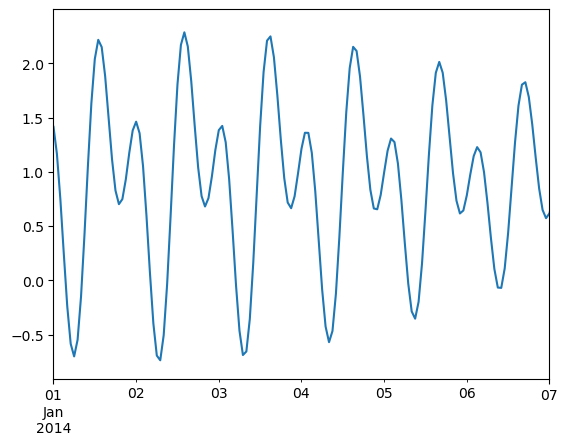

In [16]:
tide_constit=predict_tide('pr',dtvector)

In [17]:
#are we out of phase with the real data?
#9415020 is point reyes
#header is in line 8
#datatypes=[datetime, float, float, int, int, int, int, str] 
real_data=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_9415020_9415020_water_level_1950_2021.csv",skiprows=8,parse_dates=['Date Time'])#dtype=datatypes)
real_data

,Date Time,Water Level,Sigma,O or I (for verified),F,R,L,Quality
0,1995-12-01 00:00:00,NaN,NaN,1,1,1,1,p
1,1995-12-01 00:06:00,NaN,NaN,1,1,1,1,p
2,1995-12-01 00:12:00,NaN,NaN,1,1,1,1,p
3,1995-12-01 00:18:00,NaN,NaN,1,1,1,1,p
4,1995-12-01 00:24:00,NaN,NaN,1,1,1,1,p
...,...,...,...,...,...,...,...,...
2261770,2021-10-01 23:30:00,0.479,0.033,0,0,0,0,v
2261771,2021-10-01 23:36:00,0.467,0.052,0,0,0,0,v
2261772,2021-10-01 23:42:00,0.451,0.034,0,0,0,0,v
2261773,2021-10-01 23:48:00,0.412,0.042,0,0,0,0,v


In [18]:
tide_constit

Name,M2,S2,N2,K1,M4,O1,M6,MK3,S4,MN4,...,2Q1,P1,2SM2,M3,L2,2MK3,K2,M8,MS4,total
1995-12-01 00:00:00,-0.480788,0.099046,0.057636,0.138257,-0.001000,0.168206,-0.0,0.000985,-0.000488,-0.000078,...,-0.004993,-0.069293,-0.000050,0.001341,-0.004009,-0.000533,-0.016072,0.0,-0.0,0.728761
1995-12-01 01:00:00,-0.550000,0.133102,0.000014,0.040829,-0.000524,0.202793,0.0,0.000588,0.000512,-0.000882,...,-0.004807,-0.091599,0.000472,0.001994,0.000483,0.000186,0.003352,-0.0,-0.0,0.585430
1995-12-01 02:00:00,-0.481441,0.131493,-0.057612,-0.059396,0.000444,0.225430,0.0,-0.000140,0.001000,-0.000872,...,-0.004381,-0.107696,0.000859,0.001553,0.004850,0.000805,0.021874,0.0,0.0,0.528713
1995-12-01 03:00:00,-0.292286,0.094651,-0.101333,-0.155551,0.000995,0.234783,-0.0,-0.000789,0.000488,-0.000057,...,-0.003735,-0.116494,0.001000,0.000259,0.007957,0.000993,0.034503,0.0,0.0,0.555864
1995-12-01 04:00:00,-0.029915,0.032447,-0.120595,-0.241049,0.000612,0.230300,-0.0,-0.000994,-0.000512,0.000811,...,-0.002902,-0.117397,0.000855,-0.001176,0.008996,0.000650,0.037837,-0.0,0.0,0.643432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 19:00:00,-0.549396,-0.133102,0.009926,0.349303,-0.000433,0.199136,0.0,0.000999,0.000512,0.000933,...,-0.000689,0.110465,0.000429,-0.002000,-0.000643,0.000971,-0.034641,-0.0,0.0,0.816944
2020-12-30 20:00:00,-0.468100,-0.131493,0.066158,0.296570,0.000534,0.163203,0.0,0.000753,0.001000,0.000805,...,0.000430,0.096012,0.000833,-0.001437,-0.004984,0.000874,-0.037805,0.0,-0.0,0.828654
2020-12-30 21:00:00,-0.269548,-0.094651,0.106422,0.223516,0.001000,0.117652,-0.0,0.000085,0.000488,-0.000066,...,0.001527,0.075052,0.000999,-0.000085,-0.008030,0.000310,-0.030784,0.0,-0.0,0.952322
2020-12-30 22:00:00,-0.003477,-0.032447,0.121000,0.135146,0.000526,0.065168,-0.0,-0.000632,-0.000512,-0.000876,...,0.002548,0.049004,0.000879,0.001313,-0.008990,-0.000421,-0.015471,-0.0,-0.0,1.133299


In [19]:
tide_constit.index

DatetimeIndex(['1995-12-01 00:00:00', '1995-12-01 01:00:00',
               '1995-12-01 02:00:00', '1995-12-01 03:00:00',
               '1995-12-01 04:00:00', '1995-12-01 05:00:00',
               '1995-12-01 06:00:00', '1995-12-01 07:00:00',
               '1995-12-01 08:00:00', '1995-12-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=219888, freq=None)

In [20]:
real_data['Date Time'][0]

Timestamp('1995-12-01 00:00:00')

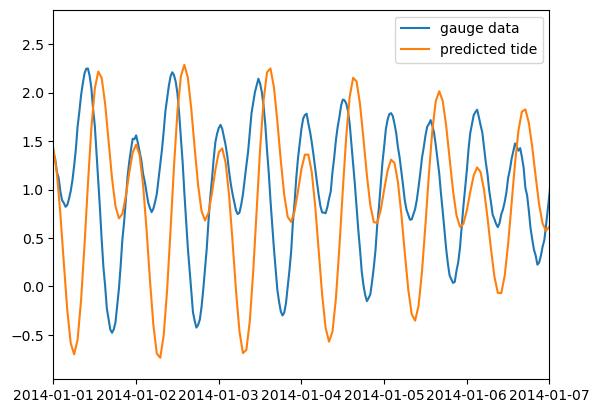

In [21]:
fig, ax =plt.subplots()
realx=real_data['Date Time'][::5]
realy=real_data[' Water Level'][::5]
ax.plot(realx,realy,label='gauge data') #space infront of the name for some reason
ax.plot(tide_constit.index,tide_constit.total,label='predicted tide')

ax.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
plt.legend()

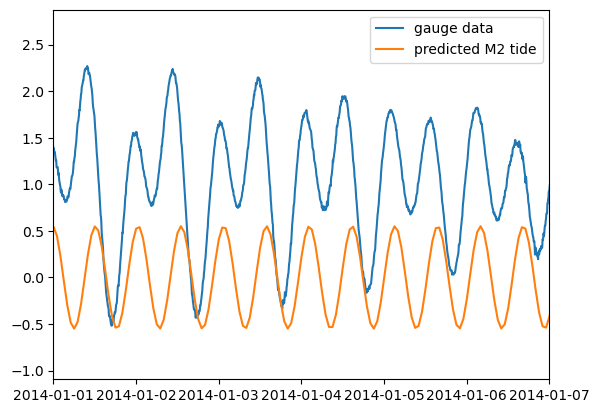

In [22]:
fig, ax =plt.subplots()
ax.plot(real_data['Date Time'],real_data[' Water Level'],label='gauge data') #space infront of the name for some reason
ax.plot(tide_constit.M2,label='predicted M2 tide')

ax.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
plt.legend()

In [23]:
coef.Speed[0]

28.984104

In [24]:
dtvector=np.arange(datetime(2014,1,1), datetime(2014,1,31), timedelta(hours=1)).astype(datetime)

In [25]:
#just m2 tide
tvector=hours_since(dtvector) #call other function to get time in hours
coef = pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/tidal_constituents_point_reyes.csv')
st=np.outer(coef.Speed[0],tvector) #speed times time = degrees
st

array([[7876488.230208, 7876517.214312, 7876546.198416, 7876575.18252 ,
        7876604.166624, 7876633.150728, 7876662.134832, 7876691.118936,
        7876720.10304 , 7876749.087144, 7876778.071248, 7876807.055352,
        7876836.039456, 7876865.02356 , 7876894.007664, 7876922.991768,
        7876951.975872, 7876980.959976, 7877009.94408 , 7877038.928184,
        7877067.912288, 7877096.896392, 7877125.880496, 7877154.8646  ,
        7877183.848704, 7877212.832808, 7877241.816912, 7877270.801016,
        7877299.78512 , 7877328.769224, 7877357.753328, 7877386.737432,
        7877415.721536, 7877444.70564 , 7877473.689744, 7877502.673848,
        7877531.657952, 7877560.642056, 7877589.62616 , 7877618.610264,
        7877647.594368, 7877676.578472, 7877705.562576, 7877734.54668 ,
        7877763.530784, 7877792.514888, 7877821.498992, 7877850.483096,
        7877879.4672  , 7877908.451304, 7877937.435408, 7877966.419512,
        7877995.403616, 7878024.38772 , 7878053.371824, 7878082.

In [26]:
coef.Speed[0]

28.984104

In [27]:
inside=st + coef.Phase[0] #speed times time plus the phase offset
inside

array([[7876806.730208, 7876835.714312, 7876864.698416, 7876893.68252 ,
        7876922.666624, 7876951.650728, 7876980.634832, 7877009.618936,
        7877038.60304 , 7877067.587144, 7877096.571248, 7877125.555352,
        7877154.539456, 7877183.52356 , 7877212.507664, 7877241.491768,
        7877270.475872, 7877299.459976, 7877328.44408 , 7877357.428184,
        7877386.412288, 7877415.396392, 7877444.380496, 7877473.3646  ,
        7877502.348704, 7877531.332808, 7877560.316912, 7877589.301016,
        7877618.28512 , 7877647.269224, 7877676.253328, 7877705.237432,
        7877734.221536, 7877763.20564 , 7877792.189744, 7877821.173848,
        7877850.157952, 7877879.142056, 7877908.12616 , 7877937.110264,
        7877966.094368, 7877995.078472, 7878024.062576, 7878053.04668 ,
        7878082.030784, 7878111.014888, 7878139.998992, 7878168.983096,
        7878197.9672  , 7878226.951304, 7878255.935408, 7878284.919512,
        7878313.903616, 7878342.88772 , 7878371.871824, 7878400.

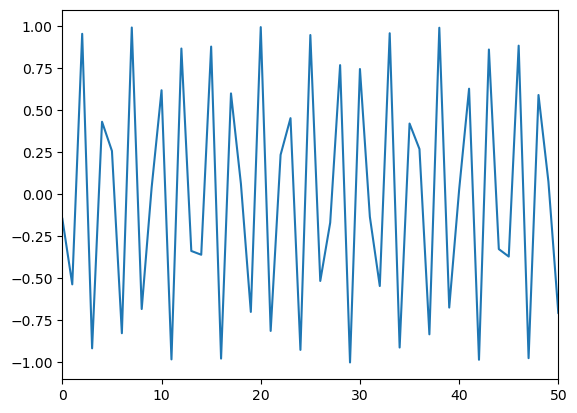

In [28]:
costerm=np.cos(inside)
fig, ax = plt.subplots()
x=np.arange(len(tvector))
ax.plot(x,costerm[0,:])
ax.set_xlim([0,50])
plt.show()

In [29]:
np.cos(np.pi)

-1.0

In [30]:
np.cos(180)

-0.5984600690578581

In [31]:
costerm[:,0:50]

array([[-0.14468156, -0.53506018,  0.95638037, -0.91579123,  0.43289635,
         0.25907733, -0.82592273,  0.99386677, -0.68179643,  0.04043436,
         0.62045655, -0.98168147,  0.86877722, -0.33627389, -0.35864185,
         0.88034197, -0.97685752,  0.60157375,  0.06425606, -0.69905171,
         0.99622173, -0.81223998,  0.23596532,  0.45427507, -0.92511122,
         0.94914031, -0.51475684, -0.16824214,  0.7699841 , -0.99984176,
         0.74679925, -0.13307018, -0.54492868,  0.95973973, -0.91101896,
         0.42229735,  0.270384  , -0.8324762 ,  0.99250188, -0.67317238,
         0.02871637,  0.62960898, -0.98384792,  0.86291134, -0.32520878,
        -0.36956201,  0.885843  , -0.97428255,  0.59216642,  0.07595222]])

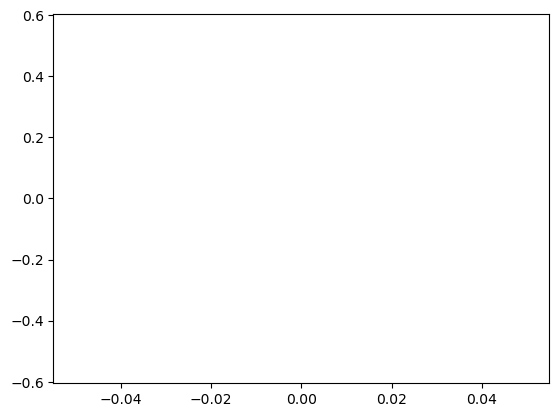

In [32]:
M2=np.multiply(coef.Amplitude[0], costerm)
fig, ax = plt.subplots()
ax.plot(M2)
plt.show()

In [33]:
# coef = pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/tidal_constituents_point_reyes.csv')

In [34]:
# check=np.outer(coef.Speed,tvector) + np.array(coef.Phase)[:,None]

In [35]:
# np.cos(check)

In [36]:
# np.multiply(np.array(coef.Amplitude)[:,None],np.cos(check))

In [37]:
# np.multiply(np.array(coef.Amplitude)[:,None], (np.cos(np.array(coef.Phase)[:,None] + np.outer(coef.Speed,tvector))))